# Exploring Dandiset 001375: Septum GABA Disruption with DREADDs

> **Note:** This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results.

## Overview

This notebook explores Dandiset 001375, which contains data from a pilot study investigating the effects of disrupting septal GABAergic activity using Designer Receptors Exclusively Activated by Designer Drugs (DREADDs) on hippocampal and neocortical activity.

You can access this dataset on the DANDI Archive at: [https://dandiarchive.org/dandiset/001375](https://dandiarchive.org/dandiset/001375)

The dataset contains recordings from two subjects (MS13B and MS14A) during sessions where they ran laps in a virtual hallway. The recordings were made using silicon probes with 128 channels per shank, positioned in various brain regions including ventral hippocampus, visual cortex, dorsal hippocampus, and parietal cortex.

## What This Notebook Covers

In this notebook, we will:

1. Load the Dandiset using the DANDI API
2. Explore the available NWB files and their basic metadata
3. Examine the electrode configuration and recording setup
4. Visualize raw electrophysiological data samples
5. Analyze trial-related information
6. Explore neural spiking activity at the single-unit level
7. Compare recordings across different sessions and brain regions

## Required Packages

The following packages are required to run this notebook:

- pynwb: Interface with NWB files
- h5py: Manage HDF5 files (the underlying format for NWB)
- remfile: Remote file access
- dandi: DANDI API client
- numpy: Numerical operations
- pandas: Data manipulation and analysis
- matplotlib: Plotting
- seaborn: Enhanced plotting

In [1]:
# Import necessary packages
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dandi.dandiapi import DandiAPIClient

# Set plot style
sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 8]

## Loading the Dandiset

First, we'll connect to the DANDI archive and load information about the Dandiset:

In [2]:
# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001375")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: https://dandiarchive.org/dandiset/001375")
print(f"Description: {metadata['description']}")

# Handle contributors which may be a complex structure
if isinstance(metadata.get('contributor', []), list):
    if metadata['contributor'] and isinstance(metadata['contributor'][0], dict):
        contributors = []
        for contributor in metadata['contributor']:
            if isinstance(contributor, str):
                contributors.append(contributor)
            elif isinstance(contributor, dict) and 'name' in contributor:
                contributors.append(contributor['name'])
            else:
                contributors.append(str(contributor))
        print(f"Contributors: {', '.join(contributors)}")
    else:
        # Just join them directly if they're strings
        print(f"Contributors: {', '.join(str(c) for c in metadata.get('contributor', []))}")
else:
    print(f"Contributors: {metadata.get('contributor', 'Unknown')}")

# List the assets in the Dandiset
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")
print("\nAssets:")
for asset in assets:
    print(f"- {asset.path}")

Dandiset name: Septum GABA disruption with DREADDs
Dandiset URL: https://dandiarchive.org/dandiset/001375
Description: Pilot study of the effect of disrupting septal gabaergic activity using DREADDs on hippocampal and neocortical activity
Contributors: Eckert, Michael, NIH Brain, McNaughton, Bruce, Ferbinteanu, Janina

Found 3 assets in the dataset

Assets:
- sub-MS13B/sub-MS13B_ses-20240725T190000_ecephys.nwb
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-12781w8_ecephys.nwb
- sub-MS14A/sub-MS14A_ses-20240906T190000_obj-ardad2_ecephys.nwb


## Exploring the NWB Files

We'll now load one of the NWB files and explore its content. We'll focus on the sub-MS13B session:

In [3]:
# URL for the first NWB file
nwb_url = "https://api.dandiarchive.org/api/assets/ce525828-8534-4b56-9e47-d2a34d1aa897/download/"

# Load the NWB file
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the NWB file
print("=== Basic Information ===")
print(f"Session Description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session Start Time: {nwb.session_start_time}")
print(f"Recording Duration: {nwb.acquisition['time_series'].data.shape[0] / nwb.acquisition['time_series'].rate:.2f} seconds")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


=== Basic Information ===
Session Description: mouse running laps in virtual hallway
Identifier: MS13B
Session Start Time: 2024-07-25 19:00:00-07:00
Recording Duration: 4822.52 seconds


### Subject Information

In [4]:
# Print subject information
print("=== Subject Information ===")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject Description: {nwb.subject.description}")
print(f"Species: {nwb.subject.species}")
print(f"Sex: {nwb.subject.sex}")
print(f"Age: {nwb.subject.age}")

=== Subject Information ===
Subject ID: MS13B
Subject Description: medial septum DREADD to suppress GABA interneurons
Species: Mus musculus
Sex: M
Age: P90D


### Electrode Setup

Let's examine the electrode configuration used in the recordings:

In [5]:
# Show electrode group information
print("=== Electrode Groups ===")
for group_name, group in nwb.electrode_groups.items():
    print(f"Group: {group_name}")
    print(f"  Description: {group.description}")
    print(f"  Location: {group.location}")
    print(f"  Device: {group.device.description} ({group.device.manufacturer})")

=== Electrode Groups ===
Group: shank1
  Description: shank1, electrodes
  Location: ventral hippocampus, visual cortex
  Device: 128 ch silicon probe (UCLA)
Group: shank2
  Description: shank2, electrodes
  Location: ventral hippocampus, visual cortex
  Device: 128 ch silicon probe (UCLA)


In [6]:
# Get electrodes information and display first few rows
electrodes_df = nwb.electrodes.to_dataframe()
print(f"Number of electrodes: {len(electrodes_df)}")
electrodes_df.head()

Number of electrodes: 256


,x,y,location,filtering,group,group_name,label
id,,,,,,,
0,20.0,1375.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13967...,shank1,shank1-electrode001
1,20.0,1325.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13967...,shank1,shank1-electrode002
2,20.0,1275.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13967...,shank1,shank1-electrode003
3,20.0,1225.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13967...,shank1,shank1-electrode004
4,20.0,1175.0,unknown,0.1 - 7500.0 Hz,shank1 pynwb.ecephys.ElectrodeGroup at 0x13967...,shank1,shank1-electrode005


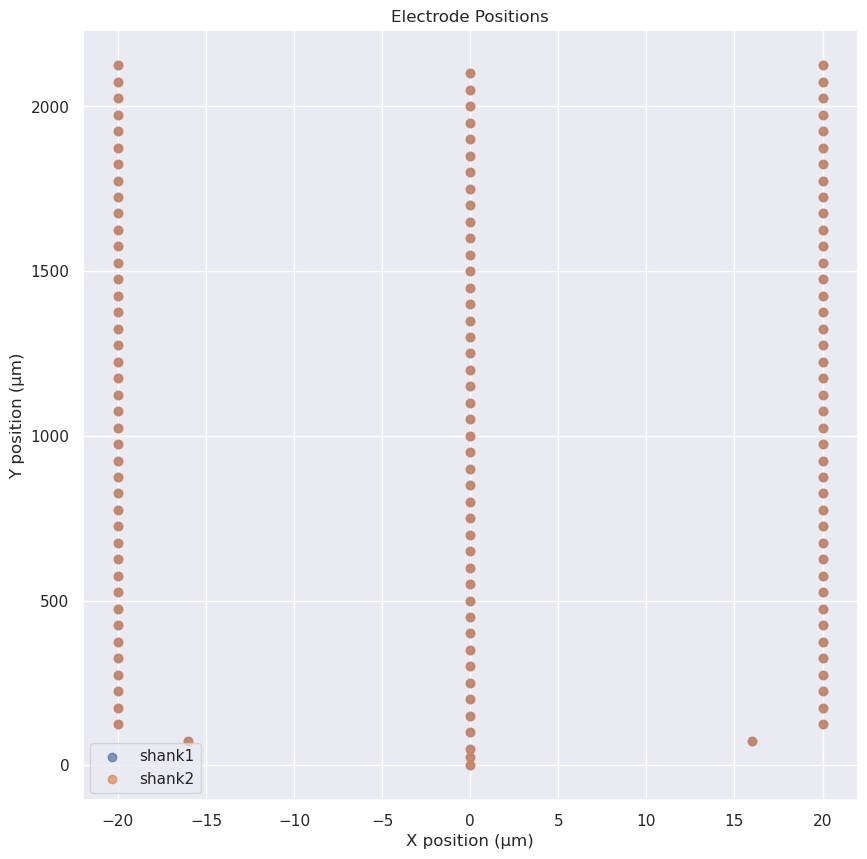

In [7]:
# Plot electrode positions
plt.figure(figsize=(10, 10))
for group_name, group_df in electrodes_df.groupby('group_name'):
    plt.scatter(group_df['x'], group_df['y'], label=group_name, alpha=0.7)
plt.xlabel('X position (μm)')
plt.ylabel('Y position (μm)')
plt.title('Electrode Positions')
plt.legend()
plt.grid(True)
plt.show()

The recording setup consists of two shanks with 128 electrodes each. Each shank has electrodes arranged in a vertical column. The shanks were positioned in the ventral hippocampus and visual cortex.

### Trials Information

Let's examine the trial structure in the experiment:

In [8]:
# Get trial information
trials_df = nwb.trials.to_dataframe()
print(f"Number of trials: {len(trials_df)}")
print("\nFirst 5 trials:")
trials_df.head()

Number of trials: 387

First 5 trials:


,start_time,stop_time
id,,
0,4.323800,16.929833
1,16.963067,28.414333
2,28.447100,39.402833
3,39.435833,50.027033
4,50.059667,63.064467


In [9]:
# Calculate trial durations
trials_df['duration'] = trials_df['stop_time'] - trials_df['start_time']
print("\nTrial duration statistics (seconds):")
print(f"  Mean: {trials_df['duration'].mean():.2f}")
print(f"  Min: {trials_df['duration'].min():.2f}")
print(f"  Max: {trials_df['duration'].max():.2f}")
print(f"  Median: {trials_df['duration'].median():.2f}")


Trial duration statistics (seconds):
  Mean: 12.30
  Min: 7.66
  Max: 164.31
  Median: 10.86


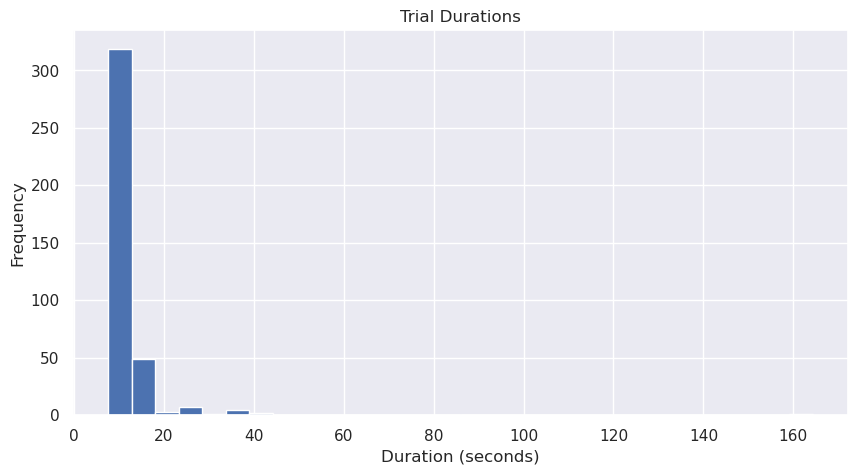

In [10]:
# Plot trial durations
plt.figure(figsize=(10, 5))
plt.hist(trials_df['duration'], bins=30)
plt.title('Trial Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

The dataset contains 387 trials with varying durations. Most trials last around 10-12 seconds, with a mean duration of approximately 12.3 seconds. There are a small number of longer trials extending up to 164 seconds, but the vast majority are less than 20 seconds.

## Exploring Raw Electrophysiological Data

Let's examine a small snippet of the raw electrophysiological data:

Time series shape: (144675584, 256)
Time series unit: mV
Sampling rate: 30000.0 Hz

Loading data from time 100.0 to 100.1 seconds
Sample range: 3000000 to 3003000


Loaded data shape: (3000, 256)


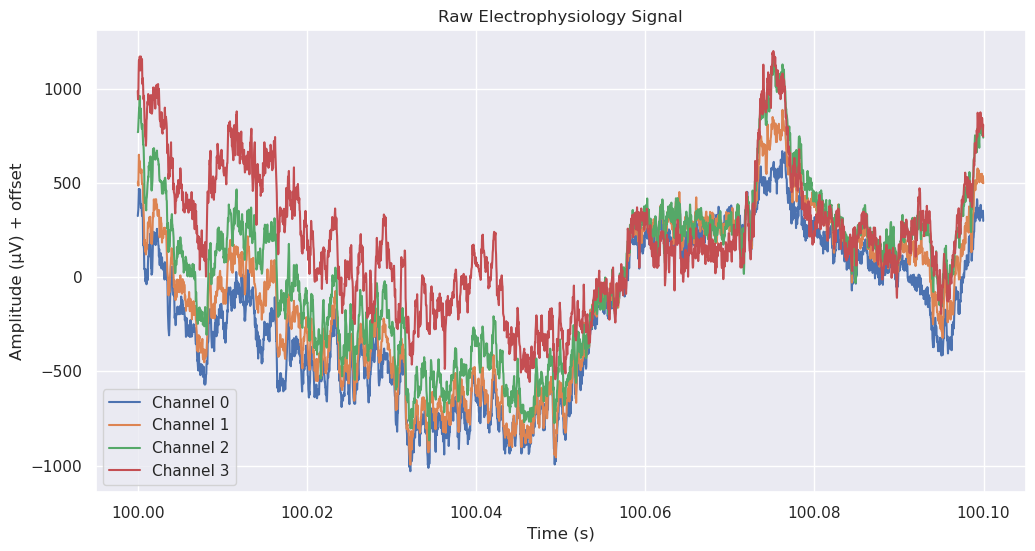

In [11]:
# Extract information about the time series
time_series = nwb.acquisition['time_series']
print(f"Time series shape: {time_series.data.shape}")
print(f"Time series unit: {time_series.unit}")
print(f"Sampling rate: {time_series.rate} Hz")

# Load a small window of data (just 0.1 seconds)
start_time = 100.0  # seconds into the recording
window_size = 0.1  # seconds
samples_to_load = int(window_size * time_series.rate)
start_sample = int(start_time * time_series.rate)

print(f"\nLoading data from time {start_time} to {start_time + window_size} seconds")
print(f"Sample range: {start_sample} to {start_sample + samples_to_load}")

raw_data = time_series.data[start_sample:start_sample + samples_to_load, :]
print(f"Loaded data shape: {raw_data.shape}")

# Select a few channels to plot
channels_to_plot = [0, 1, 2, 3]  # First few channels
time_vector = np.arange(raw_data.shape[0]) / time_series.rate + start_time

# Plot the raw data for these channels
plt.figure(figsize=(12, 6))
for i, channel in enumerate(channels_to_plot):
    # Offset each channel for visibility
    offset = i * 200  # offset in microvolts
    plt.plot(time_vector, raw_data[:, channel] + offset, label=f"Channel {channel}")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV) + offset")
plt.title("Raw Electrophysiology Signal")
plt.legend()
plt.show()

Let's also compare signals from different electrode groups (shanks):

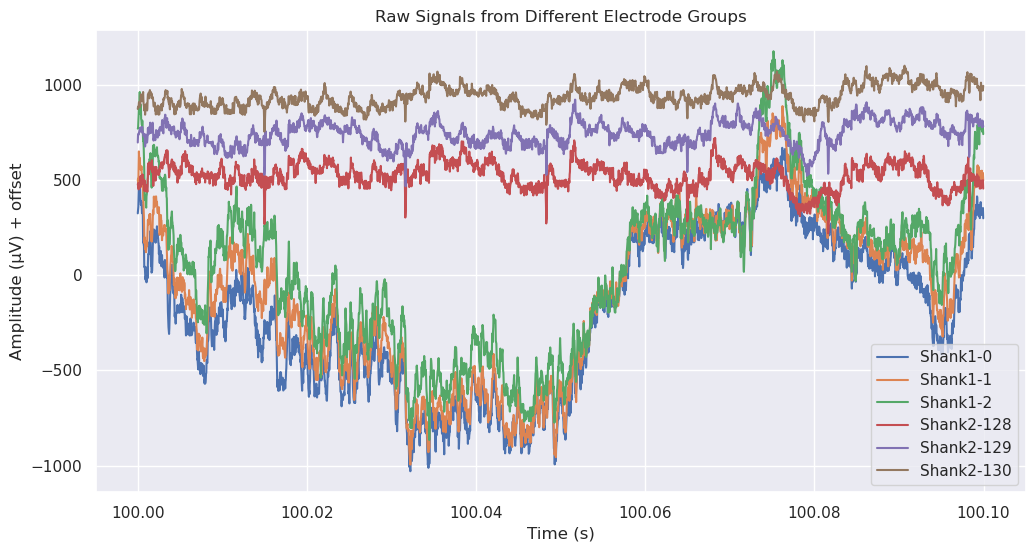

In [12]:
# Get electrodes by shank
shank1_electrode_ids = electrodes_df[electrodes_df['group_name'] == 'shank1'].index.tolist()
shank2_electrode_ids = electrodes_df[electrodes_df['group_name'] == 'shank2'].index.tolist()

# Select a few electrodes from each shank
shank1_sample = shank1_electrode_ids[:3]
shank2_sample = shank2_electrode_ids[:3]

# Plot from both shanks
plt.figure(figsize=(12, 6))
for i, channel in enumerate(shank1_sample):
    plt.plot(time_vector, raw_data[:, channel] + i * 200, label=f"Shank1-{shank1_electrode_ids[i]}")

for i, channel in enumerate(shank2_sample):
    plt.plot(time_vector, raw_data[:, channel] + (i + len(shank1_sample)) * 200, label=f"Shank2-{shank2_electrode_ids[i]}")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV) + offset")
plt.title("Raw Signals from Different Electrode Groups")
plt.legend()
plt.show()

The raw electrophysiology data shows high-frequency oscillations with varying amplitudes across different channels. We observe both slower oscillatory components and faster spiking activity. In this small sample window, the signals from different shanks appear to have different patterns, which may suggest they are recording from different neural populations or brain regions, though a more extensive analysis would be needed to confirm this observation.

## Single Unit Activity

Now let's look at the spiking activity of individual neurons (units):

In [13]:
# Get the units table
units_df = nwb.units.to_dataframe()
print(f"Number of units: {len(units_df)}")
print("First 5 units:")
units_df.head()

Number of units: 33
First 5 units:


,spike_times
id,
1,"[3.5485, 3.5543666666666667, 3.784666666666667..."
2,"[0.1826, 0.21976666666666667, 0.77823333333333..."
3,"[0.005533333333333334, 0.01633333333333333, 0...."
4,"[0.5452333333333333, 0.5632, 0.572833333333333..."
5,"[0.07036666666666666, 0.1002, 0.17066666666666..."


Let's calculate some basic statistics for each unit:

In [14]:
# Calculate basic statistics for each unit
unit_stats = []
recording_duration = nwb.acquisition['time_series'].data.shape[0] / nwb.acquisition['time_series'].rate

# Get the unit IDs
unit_ids = units_df.index.tolist()

for i, unit_id in enumerate(unit_ids):
    # Get spike times for this unit
    spike_times = nwb.units['spike_times'][i]  # Use the index i instead of unit_id
    
    # Calculate statistics
    n_spikes = len(spike_times)
    mean_rate = n_spikes / recording_duration
    
    if n_spikes > 1:
        # Calculate inter-spike intervals
        isis = np.diff(spike_times)
        mean_isi = np.mean(isis)
        cv_isi = np.std(isis) / mean_isi if mean_isi > 0 else np.nan
    else:
        mean_isi = np.nan
        cv_isi = np.nan
    
    unit_stats.append({
        'unit_id': unit_id,
        'n_spikes': n_spikes,
        'mean_rate': mean_rate,
        'mean_isi': mean_isi,
        'cv_isi': cv_isi
    })

# Convert to DataFrame
unit_stats_df = pd.DataFrame(unit_stats)
print("\nUnit statistics summary:")
print(f"Average spike rate: {unit_stats_df['mean_rate'].mean():.2f} Hz")
print(f"Min spike rate: {unit_stats_df['mean_rate'].min():.2f} Hz")
print(f"Max spike rate: {unit_stats_df['mean_rate'].max():.2f} Hz")


Unit statistics summary:
Average spike rate: 13.26 Hz
Min spike rate: 1.72 Hz
Max spike rate: 57.66 Hz


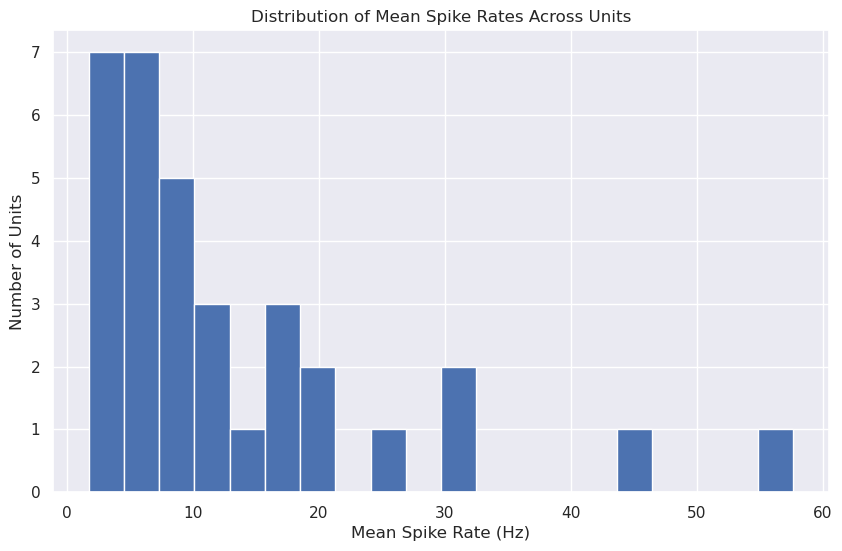

In [15]:
# Plot spike rate distribution
plt.figure(figsize=(10, 6))
plt.hist(unit_stats_df['mean_rate'], bins=20)
plt.xlabel('Mean Spike Rate (Hz)')
plt.ylabel('Number of Units')
plt.title('Distribution of Mean Spike Rates Across Units')
plt.show()

Let's examine the relationship between firing rate and firing regularity:

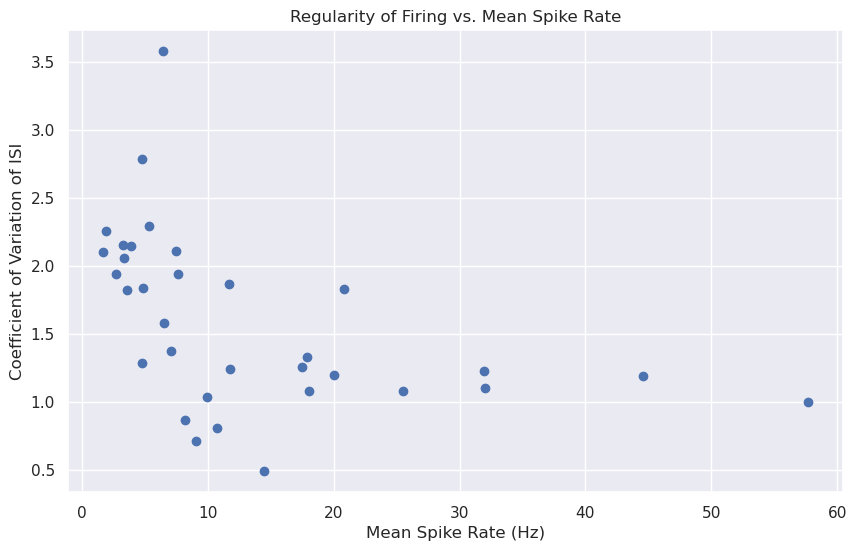

In [16]:
# Plot inter-spike interval coefficient of variation
plt.figure(figsize=(10, 6))
valid_mask = ~np.isnan(unit_stats_df['cv_isi'])
plt.scatter(
    unit_stats_df.loc[valid_mask, 'mean_rate'], 
    unit_stats_df.loc[valid_mask, 'cv_isi']
)
plt.xlabel('Mean Spike Rate (Hz)')
plt.ylabel('Coefficient of Variation of ISI')
plt.title('Regularity of Firing vs. Mean Spike Rate')
plt.show()

The analysis of the unit spike data reveals:

1. Units show a wide range of firing rates, from around 1.7 Hz to over 57 Hz, with most units having firing rates below 20 Hz.

2. The scatter plot of firing rate versus coefficient of variation (CV) of inter-spike intervals shows some variability. At lower firing rates (0-10 Hz), there's a wide range of CV values (0.5-3.5), suggesting different firing patterns among slowly firing units. For the few units with higher firing rates, the CV values appear less variable, but the sample size is too small to draw strong conclusions about a relationship between firing rate and regularity.

## Examining Spiking Activity Around Trials

Let's analyze how units fire in relation to the behavioral trials:

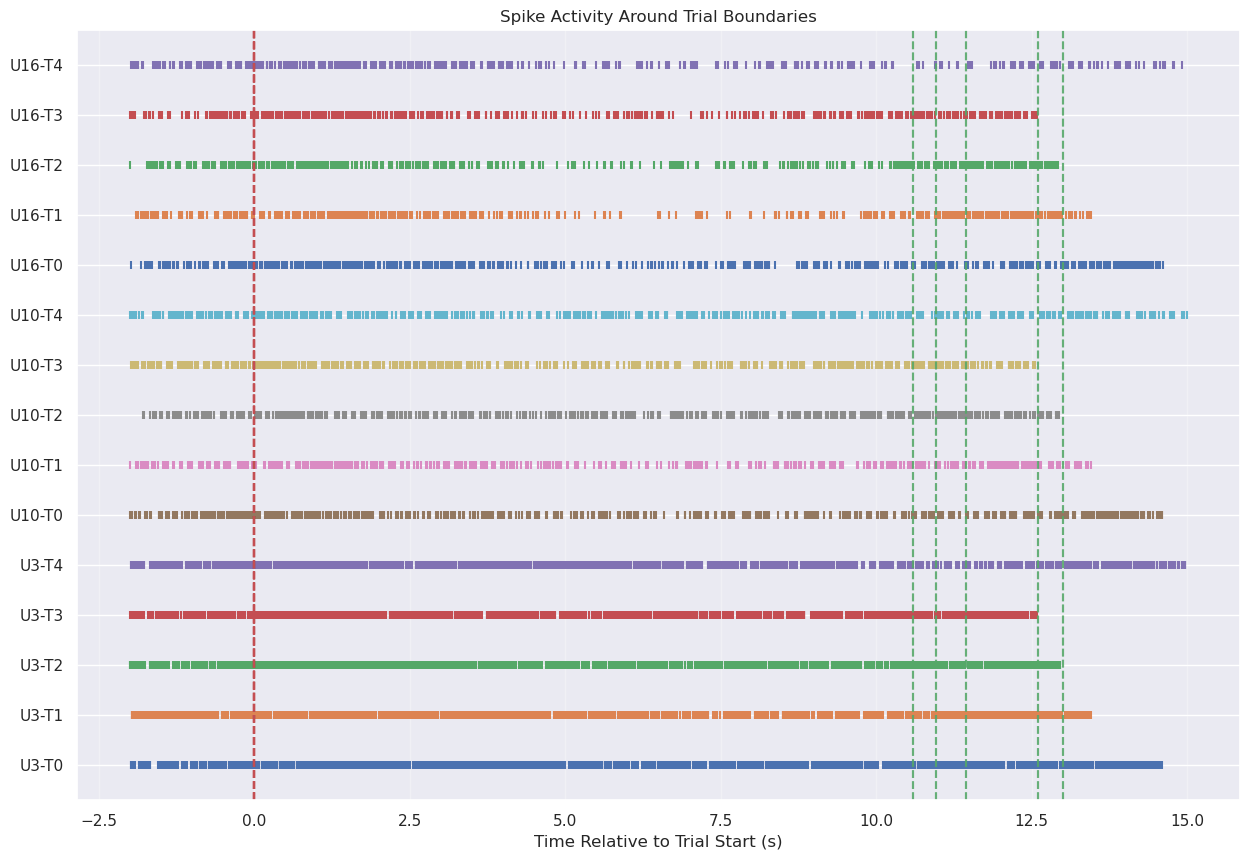

In [17]:
# Select a few units to examine in detail
top_units = unit_stats_df.sort_values('mean_rate', ascending=False).head(3)
selected_indices = [unit_ids.index(unit_id) for unit_id in top_units['unit_id']]
selected_unit_ids = top_units['unit_id'].values

# Select a couple of trials
selected_trials = trials_df.iloc[:5]  
window = 2.0  # seconds before and after trial start

plt.figure(figsize=(15, 10))
for unit_idx, (idx, unit_id) in enumerate(zip(selected_indices, selected_unit_ids)):
    spike_times = nwb.units['spike_times'][idx]
    
    for trial_idx, (trial_id, trial) in enumerate(selected_trials.iterrows()):
        trial_start = trial['start_time']
        trial_end = trial['stop_time']
        
        # Find spikes within window around trial start
        mask = (spike_times >= trial_start - window) & (spike_times <= trial_end + window)
        trial_spikes = spike_times[mask]
        
        # Normalize times relative to trial start
        rel_times = trial_spikes - trial_start
        
        # Plot
        row_idx = unit_idx * len(selected_trials) + trial_idx
        plt.scatter(rel_times, np.ones_like(rel_times) * row_idx, marker='|', s=30)
        
        # Mark trial boundaries
        plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
        plt.axvline(x=trial_end - trial_start, color='g', linestyle='--', alpha=0.5)

# Create labels
yticks = []
yticklabels = []
for unit_idx, unit_id in enumerate(selected_unit_ids):
    for trial_idx, (trial_id, _) in enumerate(selected_trials.iterrows()):
        row_idx = unit_idx * len(selected_trials) + trial_idx
        yticks.append(row_idx)
        yticklabels.append(f"U{unit_id}-T{trial_id}")

plt.yticks(yticks, yticklabels)
plt.xlabel('Time Relative to Trial Start (s)')
plt.title('Spike Activity Around Trial Boundaries')
plt.grid(axis='x', alpha=0.3)
plt.show()

The trial-aligned spike raster plot shows the activity of the three most active units during the first five trials. Red dashed lines mark trial starts, and green dashed lines mark trial ends. The spike patterns seem relatively consistent throughout the trials, without strong modulation at the trial boundaries. Different units show distinct firing patterns, with some displaying more continuous firing and others showing more discrete spiking patterns.

## Comparing Multiple Sessions

Now, let's compare data from different sessions to understand the differences:

In [18]:
# URLs for the two NWB files
url1 = "https://api.dandiarchive.org/api/assets/ce525828-8534-4b56-9e47-d2a34d1aa897/download/"  # MS13B
url2 = "https://api.dandiarchive.org/api/assets/fea95c0e-2f07-49a3-b607-4b7e9f278e16/download/"  # MS14A

# Load the second NWB file (we already have the first one loaded)
remote_file2 = remfile.File(url2)
h5_file2 = h5py.File(remote_file2)
io2 = pynwb.NWBHDF5IO(file=h5_file2)
nwb2 = io2.read()

# Compare basic information
print("=== Basic Session Information ===")
print(f"File 1 - Subject: {nwb.subject.subject_id}, Date: {nwb.session_start_time}")
print(f"File 2 - Subject: {nwb2.subject.subject_id}, Date: {nwb2.session_start_time}")

# Calculate recording durations
recording_duration1 = nwb.acquisition['time_series'].data.shape[0] / nwb.acquisition['time_series'].rate
recording_duration2 = nwb2.acquisition['time_series'].data.shape[0] / nwb2.acquisition['time_series'].rate
print(f"File 1 - Recording duration: {recording_duration1:.2f} seconds")
print(f"File 2 - Recording duration: {recording_duration2:.2f} seconds")

# Compare trial information
trials_df2 = nwb2.trials.to_dataframe()
print("\n=== Trial Information ===")
print(f"File 1 - Number of trials: {len(trials_df)}")
print(f"File 2 - Number of trials: {len(trials_df2)}")

# Calculate trial durations
trials_df['duration'] = trials_df['stop_time'] - trials_df['start_time']
trials_df2['duration'] = trials_df2['stop_time'] - trials_df2['start_time']

print("\nTrial duration statistics (seconds):")
print(f"File 1 - Mean: {trials_df['duration'].mean():.2f}, Min: {trials_df['duration'].min():.2f}, Max: {trials_df['duration'].max():.2f}")
print(f"File 2 - Mean: {trials_df2['duration'].mean():.2f}, Min: {trials_df2['duration'].min():.2f}, Max: {trials_df2['duration'].max():.2f}")

# Compare units information
units_df2 = nwb2.units.to_dataframe()
print("\n=== Units Information ===")
print(f"File 1 - Number of units: {len(units_df)}")
print(f"File 2 - Number of units: {len(units_df2)}")

# Compare electrode group locations
print("\n=== Electrode Group Locations ===")
print("File 1:")
for group_name, group in nwb.electrode_groups.items():
    print(f"  {group_name}: {group.location}")
print("File 2:")
for group_name, group in nwb2.electrode_groups.items():
    print(f"  {group_name}: {group.location}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


=== Basic Session Information ===
File 1 - Subject: MS13B, Date: 2024-07-25 19:00:00-07:00
File 2 - Subject: MS14A, Date: 2024-09-06 19:00:00-07:00
File 1 - Recording duration: 4822.52 seconds
File 2 - Recording duration: 6271.41 seconds

=== Trial Information ===
File 1 - Number of trials: 387
File 2 - Number of trials: 716

Trial duration statistics (seconds):
File 1 - Mean: 12.30, Min: 7.66, Max: 164.31
File 2 - Mean: 8.43, Min: 4.52, Max: 49.20



=== Units Information ===
File 1 - Number of units: 33
File 2 - Number of units: 58

=== Electrode Group Locations ===
File 1:
  shank1: ventral hippocampus, visual cortex
  shank2: ventral hippocampus, visual cortex
File 2:
  shank1: dorsal hippocampus, parietal cortex
  shank2: dorsal hippocampus, parietal cortex


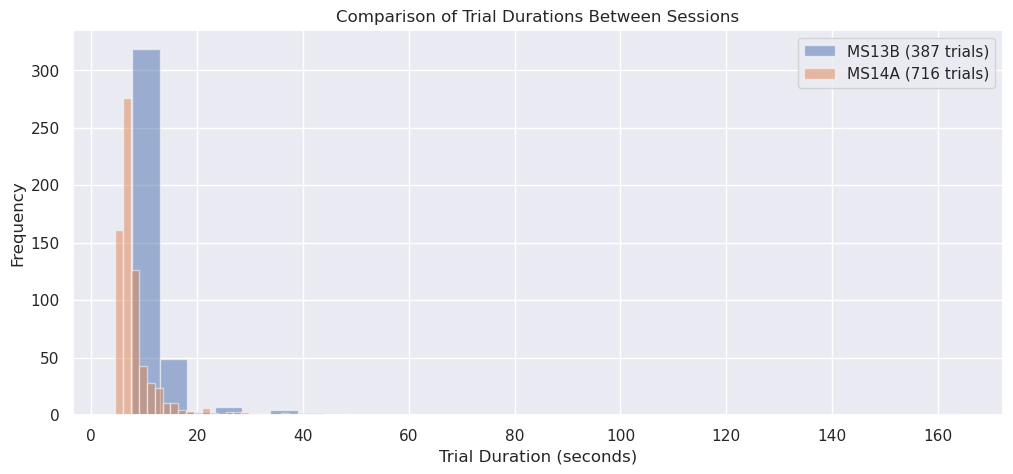

In [19]:
# Compare distributions of trial durations
plt.figure(figsize=(12, 5))
plt.hist(trials_df['duration'], bins=30, alpha=0.5, label=f'MS13B ({len(trials_df)} trials)')
plt.hist(trials_df2['duration'], bins=30, alpha=0.5, label=f'MS14A ({len(trials_df2)} trials)')
plt.xlabel('Trial Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Comparison of Trial Durations Between Sessions')
plt.legend()
plt.show()

# Close file handles
remote_file2.close()
h5_file2.close()

Comparing the two recording sessions, we observe several key differences:

1. **Recording Locations:** MS13B recordings were made in the ventral hippocampus and visual cortex, while MS14A recordings were from the dorsal hippocampus and parietal cortex.

2. **Trial Structure:** MS14A has almost twice as many trials (716) compared to MS13B (387). The trials in MS14A are generally shorter (mean duration 8.43s vs 12.30s), and MS14A shows less extreme outlier trials.

3. **Unit Count:** MS14A has more isolated units (58) compared to MS13B (33), possibly indicating better recording quality or higher neural density in the recorded regions.

4. **Recording Duration:** The MS14A session was longer (6271.41s) than MS13B (4822.52s), as calculated from the time series data shape and sampling rate.

These differences highlight the experimental approach of recording from different brain regions across sessions to understand the impact of septal GABA disruption on various neural circuits.

## Summary and Future Directions

In this notebook, we explored Dandiset 001375, which contains electrophysiological recordings investigating the effects of disrupting septal GABAergic activity using DREADDs on hippocampal and neocortical activity.

Key findings:

1. The dataset includes recordings from two subjects (MS13B and MS14A) with electrode placements in different brain regions (ventral/dorsal hippocampus, visual/parietal cortex).

2. We observed different neural activity patterns between different electrode shanks in our limited sample window, which could potentially reflect the varied activity of neural populations in different brain regions.

3. The units show a wide range of firing rates and patterns, with variations in the regularity of firing across units.

4. Trial-related neural activity shows consistent patterns across trials, though without strong modulation at trial boundaries.

Future analyses that could be performed on this dataset include:

1. More detailed analyses of neural activity locked to specific behavioral events within trials.

2. Cross-correlation analyses between units to identify functional connections.

3. Spectral analyses to examine oscillatory activity and how it might be affected by the DREADD manipulation.

4. Comparison of activity in ventral vs. dorsal hippocampus and visual vs. parietal cortex to understand regional differences in response to septal GABA disruption.

5. Machine learning approaches to classify or predict trial outcomes based on neural activity patterns.

## Cleanup

In [20]:
# Close any remaining file handles
h5_file.close()
remote_file.close()